<a href="https://colab.research.google.com/github/cherryonntopp/Brain-Tumor-Classification/blob/main/Brain_Tumor_SPIS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Shana Ibatuan
# 2025 SPIS Project
# Project: Brain Tumor Detection from MRI Scans Using Deep Learning

In [ ]:
# Installing and Importing Libraries

!pip install tensorflow matplotlib opencv-python scikit-learn

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

save_dir = "/content/drive/MyDrive/colab_checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Avoid GPU OOM (Out of Memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Load Dataset
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

print(os.listdir(path))

print("Training dataset loaded.")
print("Testing dataset loaded.")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
['Training', 'Testing']
Training dataset loaded.
Testing dataset loaded.


In [ ]:
# Load Images from Dataset

DATA_PATH = path
IMG_SIZE = 200
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_PATH, 'Training'),
    labels='inferred',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_PATH, 'Training'),
    labels='inferred',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_PATH, 'Testing'),
    labels='inferred',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of testing batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

# Checking that the labels are all the same order!
# The .class_names attribute only exists on the original dataset objects.
print("Training set class names:", train_ds.class_names)
print("Validation set class names:", val_ds.class_names)
print("Test set class names:", test_ds.class_names)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Number of training batches: 143
Number of testing batches: 41
Training set class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Validation set class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test set class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


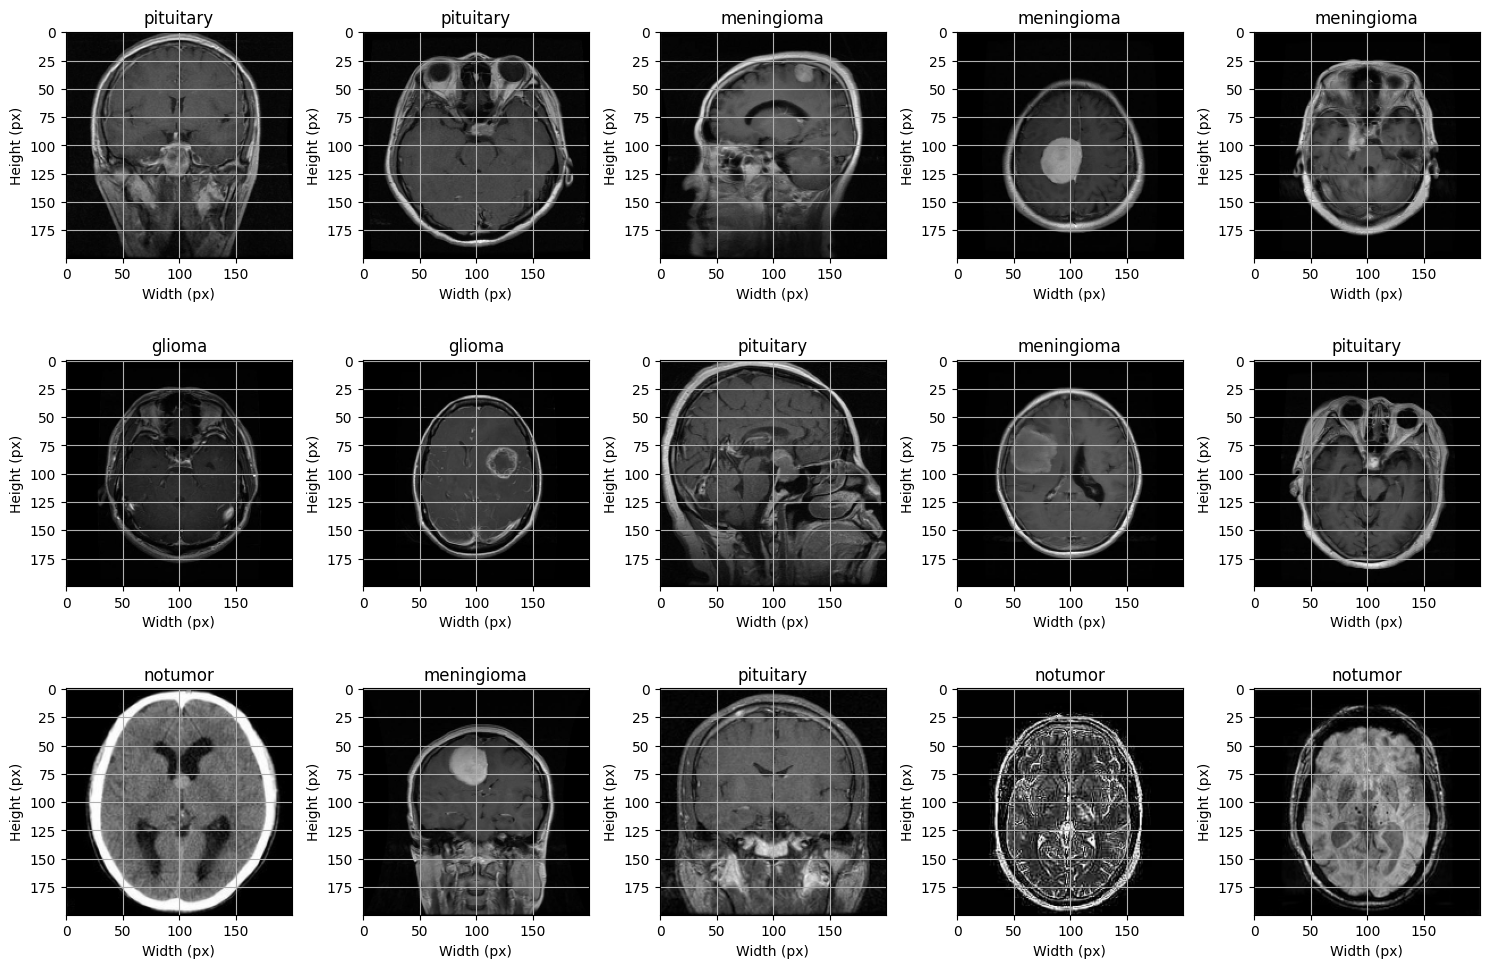

In [ ]:
#Visualizing Images from Dataset

import matplotlib.pyplot as plt
import numpy as np

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Take one batch from the training dataset
for images, labels_batch in train_ds.take(1):
    batch_images = images.numpy()
    batch_labels = labels_batch.numpy()

# Plot 15 images
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(15):
    img = batch_images[i]

    # Rescale to 0..1 to prevent matplotlib warnings
    img = (img - img.min()) / (img.max() - img.min())

    axes[i].imshow(img)
    axes[i].set_title(class_names[batch_labels[i]])
    axes[i].set_xlabel("Width (px)")
    axes[i].set_ylabel("Height (px)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Normalize and Prefetch and Splitting

# Normalizing scales image pixels to a small and consistent range
# Prefetching overlaps data loading with model

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(normalize_img).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(normalize_img).prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Data Augmentation (not called yet)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
# Building CNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input, RandomFlip, RandomRotation, RandomZoom

CLASS_COUNT = 4

model = tf.keras.Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(IMG_SIZE, IMG_SIZE,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))


model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', # Correct for integer labels
    metrics=['accuracy']
)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 196, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 43, 43, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,558,852 (36.46 MB)

 Trainable params: 9,558,852 (36.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1)
]

Checking Validation Dataset Labels
Shape of one batch of images: (32, 200, 200, 3)
Shape of one batch of labels: (32,)
Data type of labels: <dtype: 'int32'>
First 10 labels: [1 3 1 0 3 3 3 2 1 3]
Visualizing a normalized image from val_ds
Pixel values range of the first image: 0.0 to 0.9564074277877808


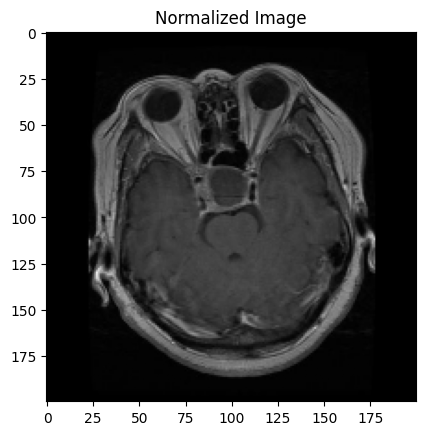

Visualizing a normalized image from val_ds
Pixel values range of the first image: 0.0 to 1.0


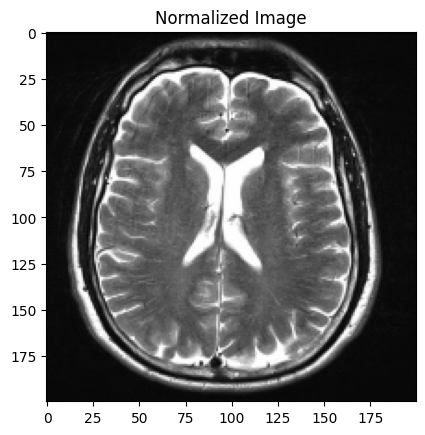

0.0 1.0


In [ ]:
# Checking Validation Dataset Labels


print("Checking Validation Dataset Labels")
for images, labels in val_ds.take(1):
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Shape of one batch of labels: {labels.shape}")
    print(f"Data type of labels: {labels.dtype}")
    print(f"First 10 labels: {labels.numpy()[:10]}")

# Checking Model's Output

import matplotlib.pyplot as plt

print("Visualizing a normalized image from val_ds")
for images, _ in val_ds.take(1):
    first_image = images[0]
    print(f"Pixel values range of the first image: {first_image.numpy().min()} to {first_image.numpy().max()}")
    plt.imshow(first_image.numpy())
    plt.title("Normalized Image")
    plt.show()

    import matplotlib.pyplot as plt

# Double-Check Normalization

print("Visualizing a normalized image from val_ds")
for images, _ in val_ds.take(1):
    first_image = images[0]
    print(f"Pixel values range of the first image: {first_image.numpy().min()} to {first_image.numpy().max()}")
    plt.imshow(first_image.numpy())
    plt.title("Normalized Image")
    plt.show()

print(first_image.numpy().min(), first_image.numpy().max())

In [ ]:
# Training Model

EPOCHS = 15

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath=save_dir + "/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1769s 12s/step - accuracy: 0.3493 - loss: 1.2733 - val_accuracy: 0.6874 - val_loss: 0.7984 - learning_rate: 1.0000e-04
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1817s 12s/step - accuracy: 0.7354 - loss: 0.6899 - val_accuracy: 0.7758 - val_loss: 0.5870 - learning_rate: 1.0000e-04
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1717s 12s/step - accuracy: 0.8101 - loss: 0.4984 - val_accuracy: 0.8660 - val_loss: 0.4504 - learning_rate: 1.0000e-04
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1704s 12s/step - accuracy: 0.8600 - loss: 0.3837 - val_accuracy: 0.8354 - val_loss: 0.4279 - learning_rate: 1.0000e-04
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1739s 12s/step - accuracy: 0.8776 - loss: 0.3076 - val_accuracy: 0.8757 - val_loss: 0.3491 - learning_rate: 1.0000e-04
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1759s 12s/step - accuracy: 0.9006 - loss: 0.2671 - val_accuracy: 0.8967 - val_loss: 0.3093 - learning_rate: 1.0000e-04
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1731s 

In [ ]:
model.save('final_model.keras')
print("Model was successfully saved")

import json

with open("history.json", "w") as f:
    json.dump(history.history, f)

print("History saved successfully.")


Model was successfully saved
History saved successfully.


In [ ]:
model.save('final_model.keras')
print("Model was successfully saved")

Model was successfully saved


In [ ]:
""" # Save Model and History
import json

model.save('final_model.keras')
with open('history.json', 'r') as f:
    json.dump(history.history, f)

print("Model and history saved successfully.")

# DON'T FORGET TO DOWNLOAD KERAS MODEL AND JSON HISTORY

print(history.history) """

' # Save Model and History\nimport json\n\nmodel.save(\'final_model.keras\')\nwith open(\'history.json\', \'r\') as f:\n    json.dump(history.history, f)\n\nprint("Model and history saved successfully.")\n\n# DON\'T FORGET TO DOWNLOAD KERAS MODEL AND JSON HISTORY\n\nprint(history.history) '

In [ ]:
#Load and Evaluate

loaded_model = tf.keras.models.load_model('final_model.keras')
test_loss, test_acc = loaded_model.evaluate(test_ds, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

41/41 - 122s - 3s/step - accuracy: 0.9497 - loss: 0.2055

Test Accuracy: 0.9496567249298096


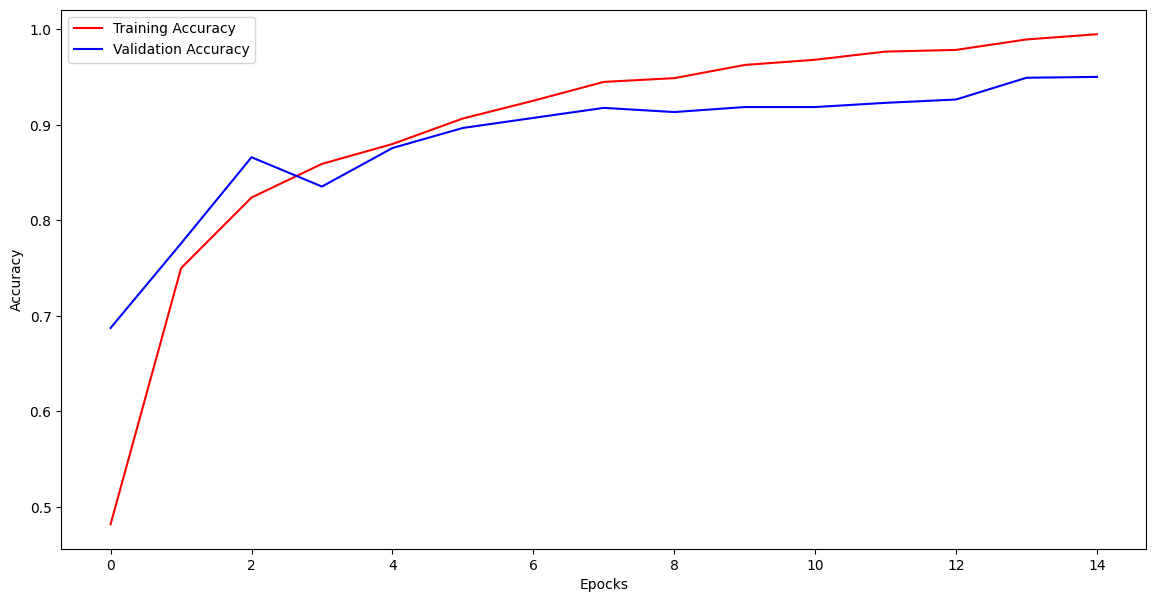

In [ ]:
# Visualizing Data -> Check for Overfitting
# Plotting Accuracy and Loss

import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')

# Labels
plt.xlabel("Epocks")
plt.ylabel("Accuracy")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


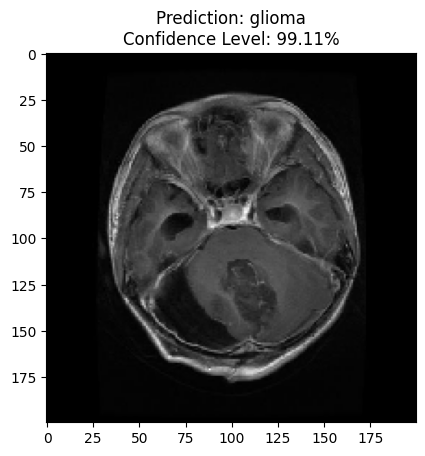

In [ ]:
# Single Image Prediction
_, IMG_SIZE, _, _ = loaded_model.input_shape
class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]

single_image_path = os.path.join(path, 'Testing', 'glioma', 'Te-glTr_0000.jpg')

def predict_image(single_image_path):
  img = tf.keras.utils.load_img(single_image_path, target_size=(IMG_SIZE, IMG_SIZE))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  predictions = loaded_model.predict(img_array)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_class_name = class_names[predicted_class_index]
  confidence = predictions[0][predicted_class_index] * 100

  plt.imshow(img)
  plt.title(f"Prediction: {predicted_class_name}\nConfidence Level: {confidence:.2f}%")
  plt.show()

predict_image(single_image_path)

In [ ]:
# Next Steps Given More Time

# Train the model on the precise location of tumor in addition to classification.
# Create boundary box surrounding the tumor or changing the tumor in the image to a different color.